<a href="https://colab.research.google.com/github/gsarm78/cs230Project/blob/master/precipitationnowcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Precipitation Nowcasting

#####**CLONE GIT REPO**

In [0]:
!git clone https://github.com/gsarm78/cs230Project.git
print("[INFO] Git repo cloned")

fatal: destination path 'cs230Project' already exists and is not an empty directory.
[INFO] Git repo cloned


####**IMPORTS**

In [0]:
import numpy as np
from PIL import Image
import os
import time
import pylab as plt
import pickle
from sklearn.metrics import classification_report
from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import Input, Add, Conv2D, Conv3D, Concatenate, ConvLSTM2D, BatchNormalization, LeakyReLU, MaxPooling2D, UpSampling2D, TimeDistributed
from keras.optimizers import *
from keras.preprocessing.image import ImageDataGenerator


import logging
logging.getLogger('tensorflow').setLevel(logging.DEBUG)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  ### NO WARNINGS!
print("[INFO] Imports loaded.")

[INFO] Imports loaded.


####**DATA LOADING AND PREPROCESSING**

In [0]:
# DATA LOADING AND PROCESSING INTO NUMPY ARRAY

IMAGE_PATH = '/content/cs230Project/samples'


WIDTH = 64
HEIGHT = 64
IMG_SEQUENCE = np.array([])
INPUT_SEQUENCE = np.array([])
NEXT_SEQUENCE = np.array([])
NUMBER = 0

def image_initialize(image):
    picture = Image.open(image)
    picture = picture.crop((243, 176, 1428, 1280))
    picture = picture.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    picture = picture.convert('L')
    data = np.array(picture.getdata()).reshape(WIDTH, HEIGHT, 1)
    return data

for file in os.listdir(IMAGE_PATH):
    image_array = image_initialize(os.path.join(IMAGE_PATH, file))
    IMG_SEQUENCE = np.append(IMG_SEQUENCE, image_array)
    NUMBER += 1

IMG_SEQUENCE = IMG_SEQUENCE.reshape(NUMBER, WIDTH * HEIGHT)
print(IMG_SEQUENCE.shape)

for i in IMG_SEQUENCE:
    for j in range(int(len(i))):
        if i[j] < 50:
            i[j] = 0

#np.savez('/content/cs230Project/data/images_sequence_array.npz', sequence_array=IMG_SEQUENCE) # test
np.savez('/content/cs230Project/data/images_sequence_array.npz', sequence_array=IMG_SEQUENCE) # original
print('[INFO] Data (images) saved as numpy compressed array')
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

(80, 4096)
[INFO] Data (images) saved as numpy compressed array
2020-03-14 23:45:18


**Format Sequence**

In [0]:
# LOADING OF NUMPY ARRAY INTO SEQUENCES #
#########################################

FRAMES = 16 #frames to process

IMG_SEQUENCE = np.load('/content/cs230Project/data/images_sequence_array.npz')['sequence_array']  # load array
print('[INFO] Image Sequence Data loaded.')
print(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()))

# Number of input images in the sequence
NUMBER = len(IMG_SEQUENCE)

IMG_SEQUENCE = IMG_SEQUENCE.reshape(NUMBER, WIDTH, HEIGHT, 1)


INPUT_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1), dtype=float)
NEXT_SEQUENCE = np.zeros((NUMBER-FRAMES, FRAMES, WIDTH, HEIGHT, 1), dtype=float)



#######
# report pixel means and standard deviations
#print('[INFO] IMG_SEQUENCE Statistics train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
#mean substraction
#IMG_SEQUENCE -=np.mean(IMG_SEQUENCE)
#print('[INFO] IMG_SEQUENCE after Zero centred train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
#IMG_SEQUENCE /= np.std(IMG_SEQUENCE)
#print('normalised train=%.3f (%.3f)' % (IMG_SEQUENCE.mean(), IMG_SEQUENCE.std()))
########

for i in range(FRAMES):
    #print(i)
    INPUT_SEQUENCE[:, i, :, :, :] = IMG_SEQUENCE[i:i+NUMBER-FRAMES]
    NEXT_SEQUENCE[:, i, :, :, :] = IMG_SEQUENCE[i+1:i+NUMBER-FRAMES+1]

print('[INFO] InputSeq Statistics=%.3f (%.3f)' % (INPUT_SEQUENCE.mean(), INPUT_SEQUENCE.std()))
print('[INFO] NextSeq Statistics=%.3f (%.3f)' % (NEXT_SEQUENCE.mean(), NEXT_SEQUENCE.std()))


print("[INFO] Input sequence ready")

[INFO] Image Sequence Data loaded.
2020-03-14 23:45:18
[INFO] InputSeq Statistics=8.420 (31.486)
[INFO] NextSeq Statistics=8.412 (31.471)
[INFO] Input sequence ready


##**MODELS**

#### Baseline Model

In [0]:
## NEW NETWORK ##
def mainmodel():
  # Inputs
  dtype='float32'

  nk = 128     # number of kernels for conv layers #48 
  fs = (3,3)  # filter size for convolutional kernels
  
  contentInput = Input(shape=(None, WIDTH, HEIGHT, 1), name='content_input', dtype=dtype)

  #Encoding Network
  x1 = ConvLSTM2D(nk, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal', name='layer1')(contentInput)
  x2 = ConvLSTM2D(nk, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal', name='layer2')(x1) 

  #Forecasting Network
  x3 = ConvLSTM2D(nk, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal', name='layer3')(x1)
  add1 = Add()([x3, x2])
  x4 = ConvLSTM2D(nk, (5,5), padding='same', return_sequences=True, kernel_initializer ='he_normal', name='layer4')(add1)

  #Prediction Network
  conc = Concatenate()([x4, x3]) #
  predictions = Conv3D(1, (5,5,5), activation='sigmoid', padding='same',  name='prediction')(conc) #sigmoid original

  model = Model(inputs=contentInput, outputs=predictions)
  
  return model

#### Test Model

In [0]:
def test_model():
  # CONVLSTM Model architecture
  model = Sequential()

  model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3),input_shape=(None, WIDTH, HEIGHT, 1), padding='same', return_sequences=True))
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', dropout=0.2, return_sequences=True))
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', dropout=0.2, return_sequences=True))
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', dropout=0.2, return_sequences=True))
  model.add(BatchNormalization())

  model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', dropout=0.2, return_sequences=True))
  model.add(BatchNormalization())

  model.add(Conv3D(filters=1, kernel_size=(3, 3, 3), activation='linear', padding='same', data_format='channels_last'))

  return model

## TRAINING

#### Training Function

In [0]:
''' # loss functions --- not used
# DICE Loss Function
def dice_loss(x, y):
  smooth = float(0.00001)
  y_true_flat = K.flatten(x) #GT
  y_pred_flat = K.flatten(y) #Prediction
  intersection = K.sum(y_true_flat * y_pred_flat)
  union = K.sum(y_true_flat) + K.sum(y_pred_flat)
  iou_nom = K.sum(intersection) + K.sum(union)
  iou_denom = K.sum(union) + K.sum(smooth)
  iou = -2*iou_nom / iou_denom
  return np.round(iou, decimals=5)

# SSIM Loss Function
def ssim_loss(x, y):
  return tf.reduce_mean(tf.image.ssim(x, y, 2.0))
'''

In [0]:
# Train model
def train(main_model=True, batchsize=5, epochs=50, save=False):

  smooth=1e-9
  #Additional metrics: SSIM, PSNR, POD, FAR
  def ssim(x, y, max_val=1.0):
    return tf.image.ssim(x, y, max_val)

  def psnr(x, y, max_val=1.0):
    return tf.image.psnr(x, y, max_val)

  #recall
  def POD(x, y):
    y_pos = K.clip(x, 0, 1)
    y_pred_pos = K.clip(y, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    tp = K.sum(y_pos * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)
    return (tp+smooth)/(tp+fn+smooth)

  def FAR(x, y):
    y_pred_pos = K.clip(y, 0, 1)
    y_pos = K.clip(x, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    return (fp)/(tp+fp+smooth)

  metrics = ['accuracy', ssim, psnr, POD, FAR]

  global history, model

  if main_model:
    model=mainmodel()
    print("[INFO] Compiling Main Model...")
    optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='logcosh', optimizer=optim, metrics=metrics) #logcosh gives better results than crossentropy or mse 
    print("[INFO] Compiling Main Model: DONE")
    print("[INFO] Training Main Model...")
    history = model.fit(INPUT_SEQUENCE[:40], NEXT_SEQUENCE[:40], batch_size=batchsize, epochs=epochs, validation_split=0.1, verbose=1, use_multiprocessing=True)
    print("[INFO] Training of Main Model: DONE")
    #Save trained model 
    if save:
      print("[INFO] Saving Model...")
      #model.save('/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.h5')
      # serialize model to JSON
      model_json = model.to_json()
      with open("/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.json", "w") as json_file:
          json_file.write(model_json)
      # serialize weights to HDF5
      model.save_weights("/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.h5")
      print("[INFO] Model Saved")
    else: print("[INFO] Model not saved")
  else:
    model=test_model()
    print("[INFO] Compiling Test Model...")
    model.compile(loss='logcosh', optimizer='adam', metrics=metrics)
    print("[INFO] Compiling Test Model: DONE")
    print("[INFO] Training Test Model...:")
    #history = model.fit(INPUT_SEQUENCE[:40], NEXT_SEQUENCE[:40], batch_size=5, epochs=180, validation_split=0.05, verbose=1, use_multiprocessing=True)
    history = model.fit(INPUT_SEQUENCE[:60], NEXT_SEQUENCE[:60], batch_size=batchsize, epochs=epochs, validation_split=0.05, verbose=1, use_multiprocessing=True)
    print("[INFO] Training of Test Model: DONE")
    #Save trained model 
    if save:
      print("[INFO] Saving Test Model...")
      model.save('/content/cs230Project/models/model1_ConvLSTM/trained_test_model_samples.h5')
      print("[INFO] Model Saved")
    else: print("[INFO] Model not saved")

####Performance Functions

In [0]:
### PLOT LOSS vs EPOCHS ###

def performance(): 
  # Plot training & validation accuracy values
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  # Plot POD/FAR plot
  plt.plot(history.history['POD'])
  plt.plot(history.history['FAR'])
  plt.title('POD, FAR plot')
  plt.ylabel('POD / FAR')
  plt.xlabel('Epoch')
  plt.legend(['POD', 'FAR'], loc='upper left')
  plt.show()

#### Fit Function

In [0]:
#Train Model

#main_model = True  trains main_model
#main_model = False trains test_model

train(main_model=True, batchsize=2, epochs=8, save=True)


[INFO] Compiling Main Model...
[INFO] Compiling Main Model: DONE
[INFO] Training Main Model...
Train on 36 samples, validate on 4 samples
Epoch 1/8
36/36 [==============================] - 46s 1s/step - loss: 8.4028 - acc: 0.8357 - ssim: 0.2580 - psnr: -29.7390 - POD: 0.6501 - FAR: 0.5792 - val_loss: 7.4414 - val_acc: 0.8661 - val_ssim: 0.4564 - val_psnr: -29.1095 - val_POD: 0.7187 - val_FAR: 0.5542
Epoch 2/8
36/36 [==============================] - 38s 1s/step - loss: 8.3724 - acc: 0.8816 - ssim: 0.4764 - psnr: -29.7272 - POD: 0.8037 - FAR: 0.4039 - val_loss: 7.4124 - val_acc: 0.9021 - val_ssim: 0.3237 - val_psnr: -29.0983 - val_POD: 0.8899 - val_FAR: 0.3394
Epoch 3/8
36/36 [==============================] - 38s 1s/step - loss: 8.3557 - acc: 0.9009 - ssim: 0.4067 - psnr: -29.7198 - POD: 0.9202 - FAR: 0.2556 - val_loss: 7.4055 - val_acc: 0.9122 - val_ssim: 0.5786 - val_psnr: -29.0948 - val_POD: 0.9387 - val_FAR: 0.2371
Epoch 4/8
36/36 [==============================] - 38s 1s/step - lo

#### Model Evalution

In [0]:
# evaluate the model
scores = model.evaluate(INPUT_SEQUENCE, NEXT_SEQUENCE, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100)) #acc
print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100)) #ssim
print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100)) #POD #recall
print("%s: %.2f%%" % (model.metrics_names[5], scores[5]*100)) #FAR

acc: 91.72%
ssim: 41.02%
POD: 97.96%
FAR: 7.90%


## VISUALISATION

#### Performance Graphs (Accuracy/Loss)

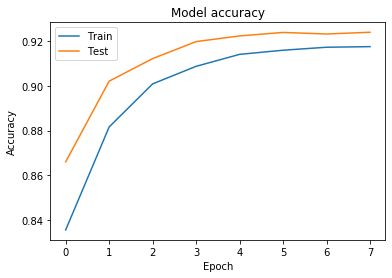

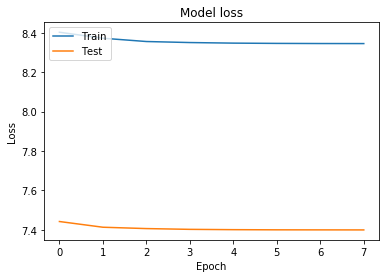

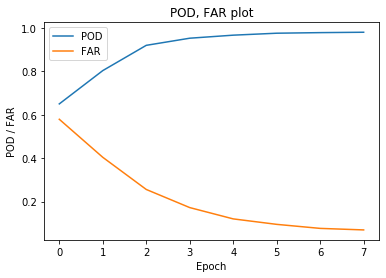

In [0]:
# Plot Performance Graphs
performance()

#### Model Summary

In [0]:
# Model Summary; Training parameters etc...

model.summary()
#mainmodel().summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      (None, None, 64, 64, 0                                            
__________________________________________________________________________________________________
layer1 (ConvLSTM2D)             (None, None, 64, 64, 1651712     content_input[0][0]              
__________________________________________________________________________________________________
layer3 (ConvLSTM2D)             (None, None, 64, 64, 3277312     layer1[0][0]                     
__________________________________________________________________________________________________
layer2 (ConvLSTM2D)             (None, None, 64, 64, 3277312     layer1[0][0]                     
____________________________________________________________________________________________

#### Model Architecture Plot

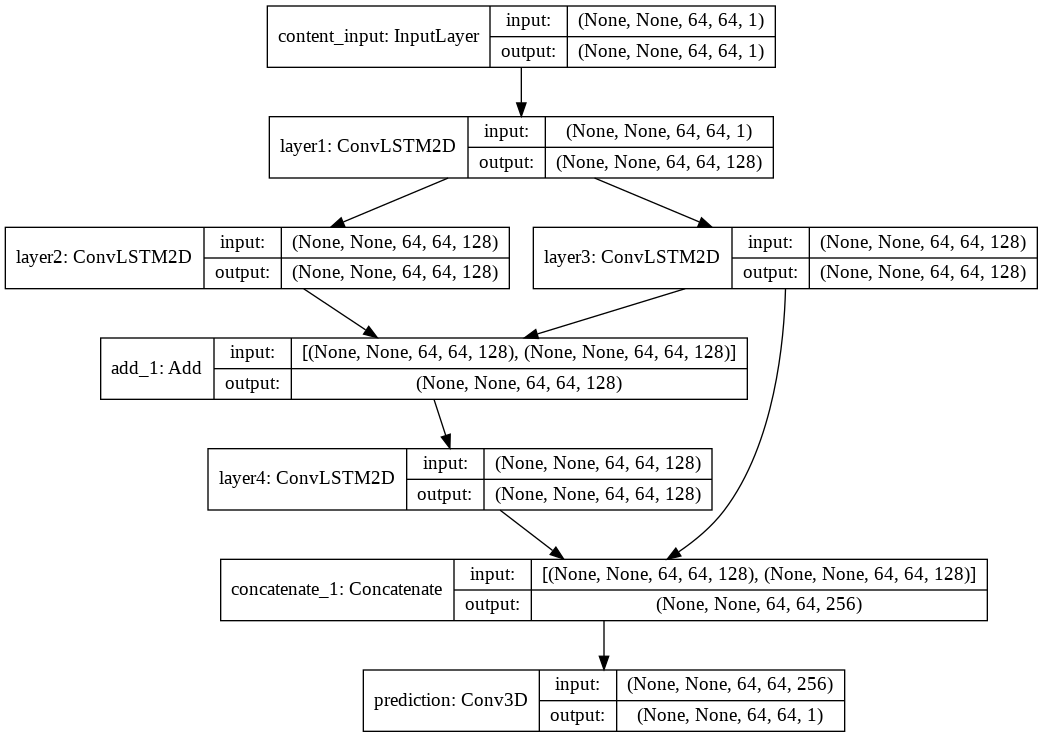

In [0]:
#Visualise Model Topology and save to file (model.png)
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='model.png')

#### Load model (optional)

In [0]:
# Uncomment to 
# Load model from storage
#model = model.load_weights("/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.h5")

# load json and create model
json_file = open('/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("/content/cs230Project/models/model1_ConvLSTM/mainmodel_1.h5")
print("[INFO] Loaded model from disk")

Loaded model from disk


####Plot Predictions

In [0]:
#which = 600
which = 20
track = INPUT_SEQUENCE[which][:8, ::, ::, ::]

In [0]:
for j in range(FRAMES+1):
    new_pos = model.predict(track[np.newaxis, ::, ::, ::, ::])
    new = new_pos[::, -1, ::, ::, ::]
    track = np.concatenate((track, new), axis=0)

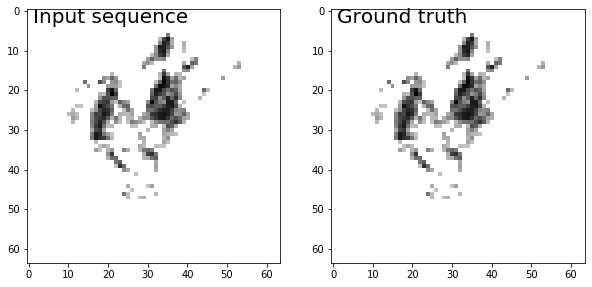

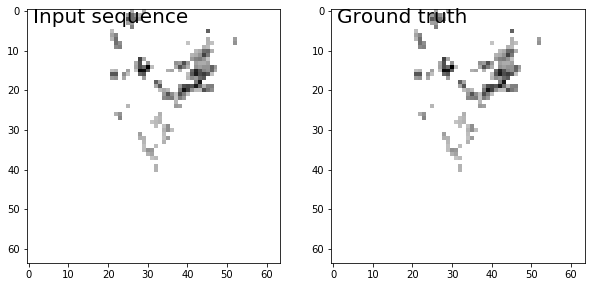

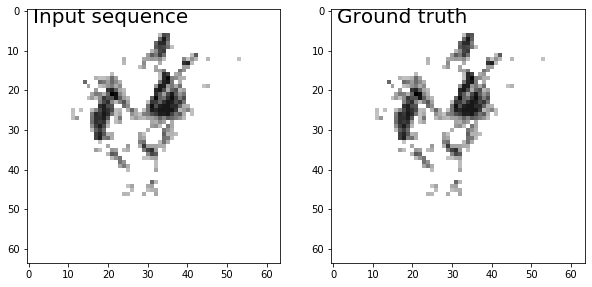

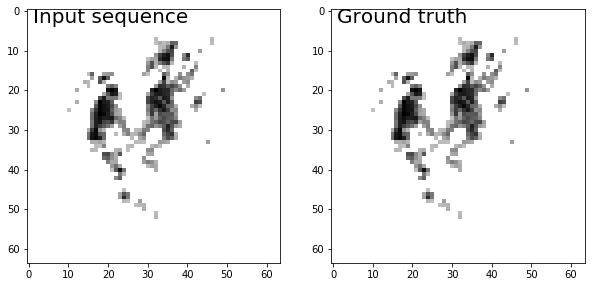

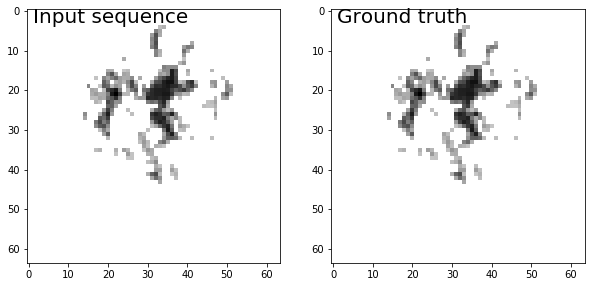

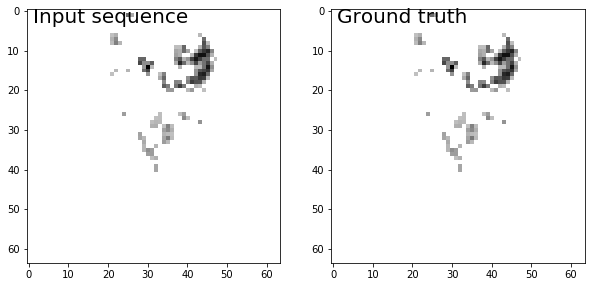

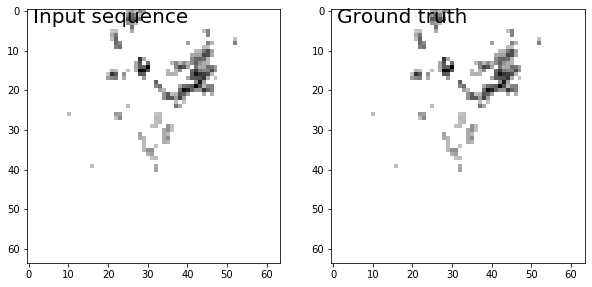

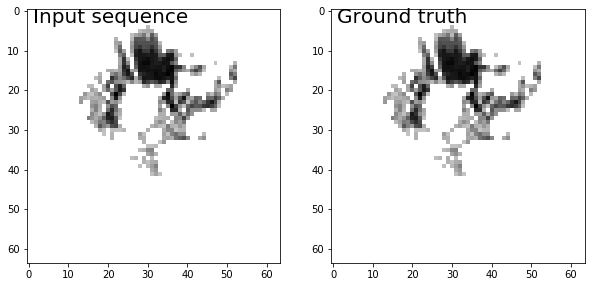

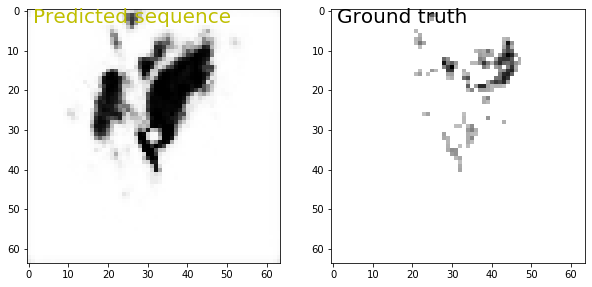

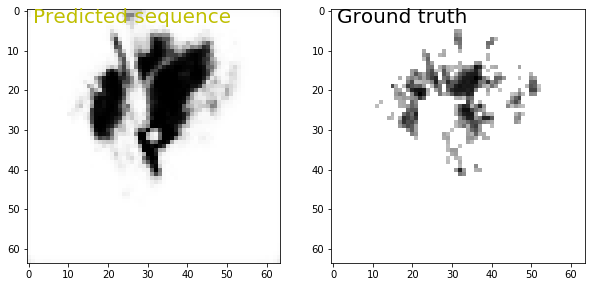

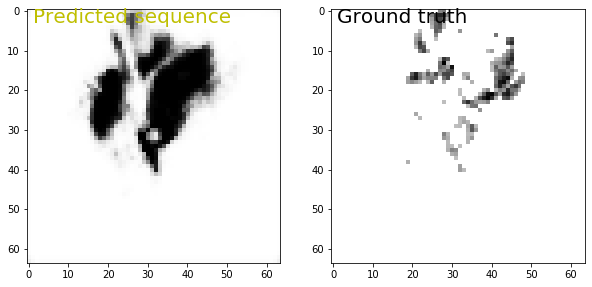

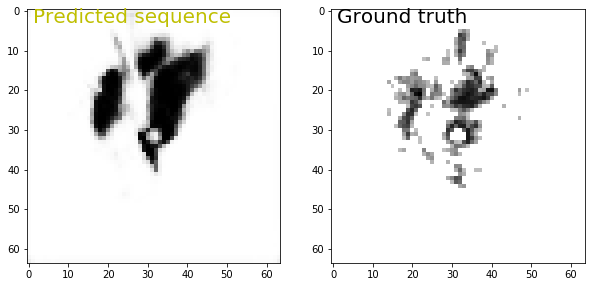

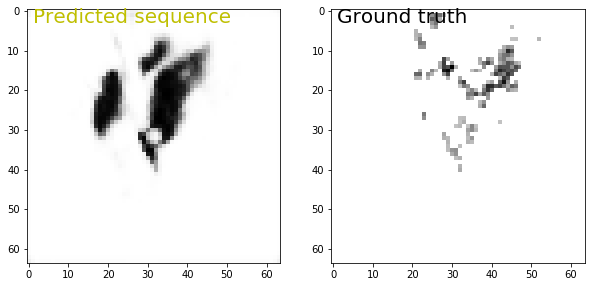

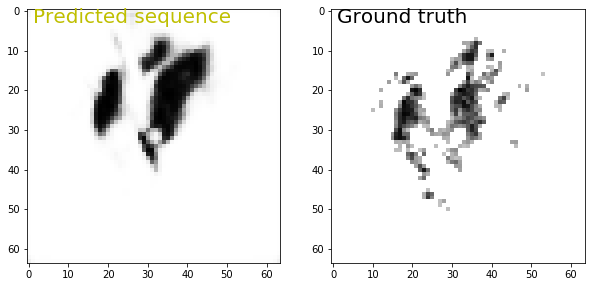

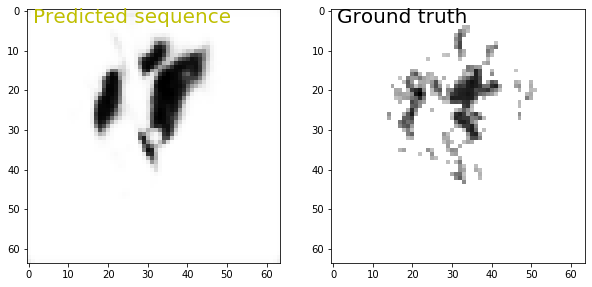

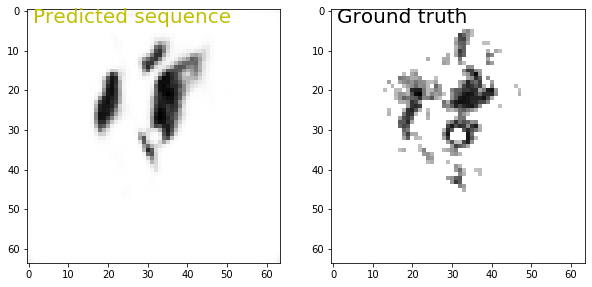

In [0]:
# And then compare the predictions
# to the ground truth
# Inspiration https://keras.io Documentation examples
track2 = INPUT_SEQUENCE[which][::, ::, ::, ::]
for i in range(FRAMES):
    fig = plt.figure(figsize=(10, 5))
    axes = fig.add_subplot(121)
    if i >= 8:
        axes.text(1, 3, 'Predicted sequence', fontsize=20, color='y')
    else:
        axes.text(1, 3, 'Input sequence', fontsize=20)
    toplot = track[i, ::, ::, 0]
    plt.imshow(toplot, cmap='binary')
    axes = fig.add_subplot(122)
    plt.text(1, 3, 'Ground truth', fontsize=20)
    toplot = track2[i, ::, ::, 0]
    if i >= 8:
        toplot = NEXT_SEQUENCE[which][i - 1, ::, ::, 0]
    plt.imshow(toplot, cmap='binary')
    plt.savefig('%i_image.png' % (i + 1))
    

####Create GIF Animation

In [0]:
# Create Animation (GIF)
import glob
from PIL import Image

# filepaths
fp_in = "*_image*.png"
fp_out = "image.gif"

img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=500, loop=0)
print("Animation generation complete. File: "+ fp_out)

Animation generation complete. File: image.gif
